In [2]:
from bowl import load_raw_data

data = load_raw_data()

train_labels.csv
test.csv
specs.csv
train.csv
sample_submission.csv


In [3]:
labels = data['train_labels.csv']

labels.loc[:, 'correct_ratio'] = labels.loc[:, 'num_correct'] / (labels.loc[:, 'num_incorrect'] + labels.loc[:, 'num_correct'])
labels.loc[:, 'correct_diff'] = labels.loc[:, 'num_correct'] - (labels.loc[:, 'num_incorrect'] + labels.loc[:, 'num_correct'])

labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,correct_ratio,correct_diff
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,0.0,-11
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,1.0,0
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2,0.5,-1
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3,1.0,0


## Are some games harder?

In [4]:
#  most common accuracy group
labels.loc[:, 'accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

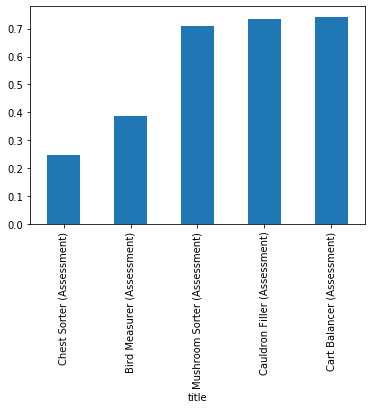

In [5]:
#  avg. accuracy per game
labels.groupby('title').mean().loc[:, 'accuracy'].sort_values().plot(kind='bar')

In [6]:
a = [0, 1, 2]
b = [0, 10, 20]

for a_, b_ in zip(a, b):
    print(a_, b_)

0 0
1 10
2 20


In [ ]:
num_played = labels.groupby('title').count().loc[:, 'game_session']

for name in num_played.index:
    print(name)
    
for value in num_played.values:
    print(value)
    
name

In [ ]:
name.split(' ')[:2] +  [' ' + str(100)]

In [ ]:
''.join(name.split(' ')[:2] +  [' ' + str(100)])

In [ ]:
new_cols = []
for name, value in zip(num_played.index, num_played.values):
    new_name = ''.join(name.split(' ')[:2] +  [' ' + str(value)])
    new_cols.append(new_name)
    
new_cols

In [ ]:
num_played.index = new_cols

grp = labels.groupby('title').mean()

grp.index = new_cols

grp.loc[:, 'accuracy'].sort_values().plot(kind='bar')

## matplotlib

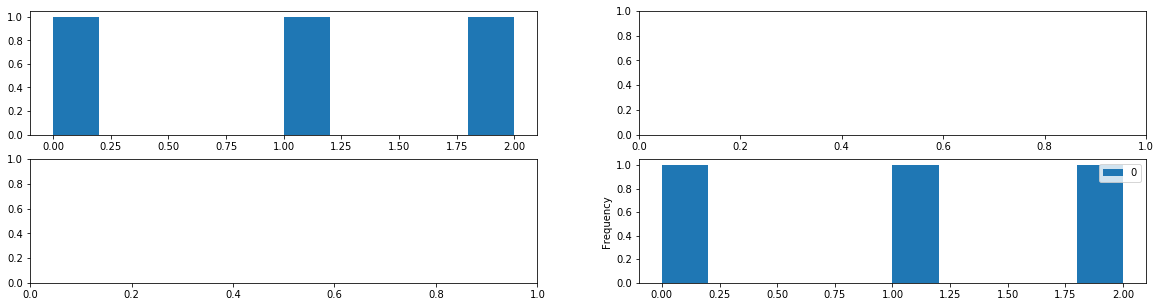

In [25]:
import matplotlib.pyplot as plt

#plt.plot(np.array([0, 1, 2]))

#  with pandas
df = pd.DataFrame(np.array([0, 1, 2]))
#df.plot(kind='hist')

#  fig, ax
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 5))
axes[0, 0].hist(np.array([0, 1, 2]))
df.plot(ax=axes[1, 1], kind='hist')
fig.savefig('fig.png')

In [ ]:
labels.groupby(['title', 'accuracy_group']).describe()

In [ ]:
labels.groupby('title').sum()

In [ ]:
labels.loc[:, 'accuracy_group'].value_counts()